[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Dens49/seminar-deeplearning-sgd/blob/master/notebook_main.ipynb)

#### Note on running the notebook in google colab

Make sure to run this notebook either in google colab or **preferrably in a jupyter lab instance** since github destroys some markdown table layouts. In case the Open in Colab badge doesn't send you to colab, try clicking next to it or just copy paste the url manually.

When running in **google colab** you should upload the whole workspace (github repo) to your google drive at your google drive root in a folder called **seminar_dl_workspace**. Each notebook in this repo contains the code necessary to mount that folder in google drive under **/content/drive/My Drive/seminar_dl_workspace** to the colab VM and changes the current working directory to that.<br>
This main notebook tries to clone the git repository to that folder in your google drive if it doesn't exist, yet. If you choose to use a folder name different from **seminar_dl_workspace** then make sure to change it in the other notebooks as well!

# Seminar Deep Learning - Stochastic Gradient Descent

*Hochschule Offenburg*

*Dennis Bystrow, INFM-3*

*the presentation can be found in folder __presentation__*

In [1]:
# just some boilerplate for necessary imports + google colab + google drive support

%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import time

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

import os
if IN_COLAB:
    print("running in google colab")
    from google.colab import drive
    drive.mount("/content/drive")
    # change as you like
    workspace_dir = "/content/drive/My Drive/seminar_dl_workspace"
    workspace_dir_escaped = workspace_dir.replace(" ", "\ ") # escape spaces for cli
    
    # clone the workspace if necessary
    if not os.path.isdir(workspace_dir) and str(input("It seems the github repo isn't cloned, yet. Do you want to clone it now? [yN]\n")) == "y":
        !git clone https://github.com/Dens49/seminar-deeplearning-sgd.git $workspace_dir_escaped
    
    os.chdir(workspace_dir)
    print("switched workspace:", os.getcwd())
    
    # humanfriendly is only used in notebook_main.ipynb
    !pip install humanfriendly

from humanfriendly import format_timespan

from gradvis import resnets
from create_visualizations import get_filenames_in_dir, create_plots_from_checkpoints, TrainVisCIFAR10
from experiment import Experiment
from experiment_runner import run_experiment
    
from IPython.display import SVG, display
def show_svg(filename):
    display(SVG(filename=filename))

## Table of Contents

1. [Introduction](#introduction)
2. [The CIFAR-10 dataset](#dataset)
3. [The experiments](#experiments)
4. [Summary of results](#results-summary)
5. [Loss landscape visualization with Gradvis](#gradvis)
6. [Full training example](#full-training-example)
7. [Sources](#sources)

## 1. Introduction<a name="introduction" />

The notebook [Gradient Descent toy notebook](./notebook_gradient_descent_toy_examples.ipynb) contains introductory examples for gradient descent.<br>
The notebook contains the following examples:
- Gradient Descent for 1 variable
- Gradient Descent for 2 variables
- Gradient Descent with Momentum for 2 variables
- Linear Regression with Gradient Descent

##### Gradient Descent: finding the minimum of $y=x^2$
![gd one variable](./visualizations/gradient_descent_1d_example.png)

##### Gradient Descent: finding the minimum of $y=x_1^2+2x_2^2$
![gd two variables](./visualizations/gradient_descent_2d_example.png)

##### Gradient Descent with Momentum: finding the minimum of $y=x_1^2+2x_2^2$
![momentum two variables](./visualizations/momentum_2d_example.png)

##### Linear Regression using Gradient Descent
![linear regression](./visualizations/gradient_descent_linear_regression_example.png)

## 2. The CIFAR-10 dataset <a name="dataset" />

The dataset CIFAR10 [https://www.cs.toronto.edu/~kriz/cifar.html](https://www.cs.toronto.edu/~kriz/cifar.html) was used.

Quick Facts:
- CIFAR-10 is a labeled subset of the **80 million tiny images** dataset [http://groups.csail.mit.edu/vision/TinyImages/](http://groups.csail.mit.edu/vision/TinyImages/)
- 60'000 coloured images
- 50'000 training examples and 10'000 test examples
- contains 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- test set contains 1'000 random images of each class
- Image size: 32x32 pixels
- best test accuracy: 99.3% submitted on 24.12.2019 ([https://arxiv.org/abs/1912.11370v1](https://arxiv.org/abs/1912.11370v1))

There is no need to download the dataset manually when using PyTorch.

The CIFAR10 dataset is included in the torchvision library. The created scripts will check the existence of the dataset and download it automatically via code only: [https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#loading-and-normalizing-cifar10](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#loading-and-normalizing-cifar10). Torchvision also already handles the train and test split.

## 3. The experiments <a name="experiments" />

### Experiment setup

The used anaconda environment is documented in **requirements.txt**.<br>This project doesn't use any python packages that aren't already available in a google colab environment **except for _[humanfriendly](https://pypi.org/project/humanfriendly/)_**.<br>The requirements file is just there for documentation and to make sure that you can find a missing package if necessary.

The framework PyTorch is used.

A small PyTorch wrapper for the experiments was created, since all experiments differ only in the used optimizer (and hyper parameters), batch size and optionally learning rate scheduling.

The wrapper is located in **experiment_runner.py** which runs a configured experiment as defined in **experiment.py**

The code in **experiment.py** documents how to create the examined optimizers and lr schedulers (using a framework like PyTorch makes this very easy).

The wrapper uses an existing, untrained resnet20 implementation from [https://github.com/cc-hpc-itwm/GradVis/blob/master/Examples/resnet20_example.py](https://github.com/cc-hpc-itwm/GradVis/blob/master/Examples/resnet20_example.py) for all experiments.<br>
Every epoch is saved automatically as a checkpoint.

The wrapper tries to run the experiment using the gpu but will default to cpu if cuda isn't supported or installed. Stdout will inform you on which device is used.

There are notebooks to run the experiments for an optimizer (called \*\_runner.ipynb) and to read results and create visualizations (called \*\_results.ipynb).

The config of each experiment along with all results per epoch are stored in a separate csv file in the folder **experiments\_stats**. The experiment title contains the important used hyper parameter values and is used as filename for the csv file and PyTorch neural network checkpoint during training. Every Epoch of every experiment is saved as a checkpoint so that training could be continued after a crash and the checkpoints are necessary for the usage of the library gradvis that creates loss landscape visualizations for the training process.

### Experiment result csv structure

The results of all experiments can be found in the folder **experiments_stats**. One file for each experiment. Results (acc, loss, timestamp, ...) for each epoch are one row. Multiple runs of the same experiment are stored in the same csv file but with different experiment ids.

Structure of the csv files:

| experiment_id | experiment_title | epoch | epoch_amount | train_avg_loss | train_acc | test_avg_loss | test_acc | experiment_params | timestamp |
| - | - | - | - | - | - | - | - | - | - |

### Experiment description

There are three rounds of experiments. In _round one_ the optimizers **Mini-Batch SGD, Momentum, AdaGrad and RMSProp** did undergo hyper parameter grid search where every experiment runs for 20 epochs. In _round two_ the best hyper parameter combination for each optimizer was selected for a 100 epochs test run. _Round three_ consists of only one experiment. It used the best optimizer from round two and added learning rate scheduling with cosine annealling to that. At the end a 1'000 epoch run for this experiment was done, but due to the fact that the long training didn't improve the test accuracy and loss any more, it wasn't continued after the connection to google colab was lost after 896 epochs.

At the [end of this notebook](#full-training-example) there is a full training example that shows the usage of **experiment.py**, **experiment_runner.py** and **create_visualizations.py** (for GradVis) and also an example for creating a small visualization of the saved training results with pandas and matplotlib.<br>
The **Runner** and **Results** notebooks in the following table act as documentation for the actual experiments that were run and for the creation of result visualizations.

### Experiments with 20 epochs
| Experiment | Runner notebook | Results notebook | Experiment title structure | Hyper parameters tested | No. of total experiments |
| - | - | - | - | - | -: |
| Mini-Batch SGD | [Mini-Batch Runner](./notebook_experiments_mini-batch_runner.ipynb) | [Mini-Batch Results](./notebook_experiments_mini-batch_results.ipynb) | SGD\_with\_variable\_batch\_size\_**[batch-size]**\_**[learning rate]** | Batch Size, Learning Rate | 338 |
| Momentum | [Momentum Runner](./notebook_experiments_momentum_runner.ipynb) | [Momentum Results](./notebook_experiments_momentum_results.ipynb) | SGD\_with\_momentum\_**[gamma]**\_**[batch-size]**\_**[learning rate]** | Batch Size, Learning Rate, Gamma | 72 |
| AdaGrad | [AdaGrad Runner](./notebook_experiments_adagrad_runner.ipynb) | [AdaGrad Results](./notebook_experiments_adagrad_results.ipynb) | Adagrad\_batch\_size\_**[batch-size]** | Batch Size | 10 |
| RMSProp | [RMSProp Runner](./notebook_experiments_rmsprop_runner.ipynb) | [RMSProp Results](./notebook_experiments_rmsprop_results.ipynb) | RMSprop\_**[gamma]**\_**[batch-size]** | Batch Size, Gamma (different from Momentum's Gamma) | 20 |
| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | **total: 440** |

### Experiments with 100 epochs and one experiment with 896 epochs

- [Runner notebook for all 100 epoch experiments and the one 896 epochs experiment](./notebook_experiments_100_epochs_runner.ipynb)
- [Results notebook for all 100 epoch experiments and the one 896 epochs experiment](./notebook_total_results.ipynb) (also contains summary of all the results from the 20 epoch experiments)

## 4. Summary of results <a name="results-summary" />

### Summary of absolute best learning results as table
| &nbsp; | **20 epochs** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | **100 epochs** | &nbsp; | &nbsp; | &nbsp; | **best param combination found** |
| - | - | - | - | - | - | - | - | - | - | -: |
| **Experiment** | **train acc** | **test acc** | **train avg loss** | **test avg loss** | &nbsp; | **train acc**  | **test acc** | **train avg loss** | **test avg loss** |
&nbsp;
| **Mini-Batch SGD** | 0.954 | 0.836 | 0.131 | 0.631 | &nbsp; | 0.9996 | 0.8388 | 0.0015 | 0.5969 | lr: 0.35<br>batch-size: 16 |
| **Momentum** | 0.952 | 0.841 | 0.137 | 0.596 | &nbsp; | 0.9995 | 0.8425 | 0.0018 | 0.5498 | lr: 0.04<br>batch-size: 16<br>gamma: 0.9 |
| **AdaGrad** | 0.861 | 0.780 | 0.413 | 0.660 | &nbsp; | 0.9832 | 0.7720 | 0.0604 | 0.6728 | [PyTorch defaults](https://pytorch.org/docs/stable/optim.html#torch.optim.Adagrad)<br>batch-size: 8 |
| **RMSprop** | 0.945 | 0.838 | 0.152 | 0.644 | &nbsp; | 0.9910 | 0.8319 | 0.0290 | 0.5638 | [PyTorch defaults](https://pytorch.org/docs/stable/optim.html#torch.optim.RMSprop)<br>lr: 0.001<br>batch-size: 16<br>gamma: 0.9 |
| **Momentum with Cosine<br>Annealling learning<br>rate scheduling** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | 1.0000 | **<span style="color: red;">0.8564<br>best test acc!</span>** | 0.000253 | 0.4851 | same as Momentum<br>for cosine annealling:<br>T_0: 7<br>T_mult: 2 |
&nbsp;
| &nbsp; | **896 epochs** | &nbsp; | &nbsp; | &nbsp; | **params** |
| **Experiment** | **train acc** | **test acc** | **train avg loss** | **test avg loss** |
| **Momentum with Cosine<br>Annealling learning<br>rate scheduling** | 1.0 | 0.8533 | 0.0 | 0.5047 | same as in the<br>100 epochs experiment |

### Summary as visualizations for every relevant experiment group

These are visualizations created from training data that can be found in the folder **experiments_stats**. They compare training outcomes with different sets of hyper parameters. For the specific best parameters of each experiment group refer to [the table summary](#Summary-of-absolute-best-learning-results-as-table). The visualizations were created with the **\*results** notebooks and are in the folder **visualizations**.

#### Mini-Batch SGD
![mini batch sgd](./visualizations/sgd_batch_size_vs_learning_rate_heat_maps.png)

##### Same data as line plot
![mini batch sgd lines](./visualizations/sgd_batch_size_vs_learning_rate_lines_big.png)

#### Momentum
![momentum](./visualizations/sgd_with_momentum_batch_sizes.png)

#### AdaGrad
![adagrad](./visualizations/adagrad_batch_sizes.png)

#### RMSProp
![rmsprop](./visualizations/rmsprop_batch_sizes.png)

#### 100 epochs results
![100 epochs results](./visualizations/final_100_epochs_4.png)

#### 896 epochs results
![896 epochs results](./visualizations/sgd_momentum_lr_scheduled_896_epochs.png)

##### Learning Rate per epoch of the used learning rate schedule (896 epochs)
![learning rate cosine annealling 896 epochs](./visualizations/cosine_annealling_learning_rate_896_epochs_T0-7_Tmult-2.png)

##### Learning Rate per epoch of the used learning rate schedule (100 epochs)
![learning rate cosine annealling 100 epochs](./visualizations/cosine_annealling_learning_rate_100_epochs_T0-7_Tmult-2.png)

### Fun fact: total training time

In [12]:
total_seconds = 0
total_experiments = 0 # also includes those that weren't finished
str_to_unix_timestamp = lambda x: int(time.mktime(time.strptime(x, "%Y-%m-%d %H:%M:%S.%f")))

all_round_one = list(map(lambda x: os.path.join("experiments_stats", x), get_filenames_in_dir("experiments_stats")))
all_round_two_and_three = list(map(lambda x: os.path.join("experiments_stats", "100_epochs", x), get_filenames_in_dir("experiments_stats/100_epochs")))
large_experiment = "experiments_stats/dont_use/SGD_with_momentum_and_lr_scheduled_larger_1000_epochs_batch_size_16_lr_0.04_momentum_0.9.csv"
all_files = all_round_one + all_round_two_and_three + [large_experiment]

df = pd.concat(map(lambda x: pd.read_csv(x), all_files), ignore_index=True)
df_grouped = df.groupby("experiment_title")
for group_name, group in df_grouped:
    by_id = group.groupby("experiment_id")
    for id_group_name, id_group in by_id:
        total_seconds += str_to_unix_timestamp(id_group["timestamp"].iloc[-1]) - str_to_unix_timestamp(id_group["timestamp"].iloc[0])
        total_experiments += 1
              
avg_seconds = total_seconds / total_experiments
print(f"total time for all {total_experiments} started experiments: {format_timespan(total_seconds)} ({round(total_seconds / 3600, 2)} hours)")
print(f"avg time per experiment: {format_timespan(avg_seconds)}")

total time for all 461 started experiments: 4 days, 14 hours and 1 minute (110.03 hours)
avg time per experiment: 14 minutes and 19.23 seconds


### Fun fact: total size of stored checkpoints (GiB)

The checkpoint for one epoch roughly the size: **1.067383 MiB**

In [13]:
mibs = len(df) * 1.067383
print(f"Total space taken up by {len(df)} checkpoints: {round(mibs / 1024, 4)} GiB")

Total space taken up by 10436 checkpoints: 10.8781 GiB


## 5. Loss landscape visualization with Gradvis <a name="gradvis" />

"[GradVis](https://github.com/cc-hpc-itwm/GradVis) allows to plot 2d and 3d projections of optimization surfaces and trajectories" [https://arxiv.org/abs/1909.12108](https://arxiv.org/abs/1909.12108)

A slightly modified version of GradVis (see folder **gradvis**) was used in this project to create 2d and 3d plots of the trajectory through the loss surface.<br>
The generated visualizations however didn't provide to be a good visual comparison between the trajectories taken by different optimization algorithms and were therefore left out of the presentation.

GradVis needs to access all checkpoints of the training of a model. The created PyTorch wrapper in **experiment_runner.py** takes care of storing a checkpoint of every epoch.

The following two examples from the experiments were kept for demonstration purposes.<br>
The generated visualizations can be found in the folders
- **visualizations/SGD_with_variable_batch_size_16_0.35**
- **visualizations/SGD_with_momentum_0.9_16_0.04**

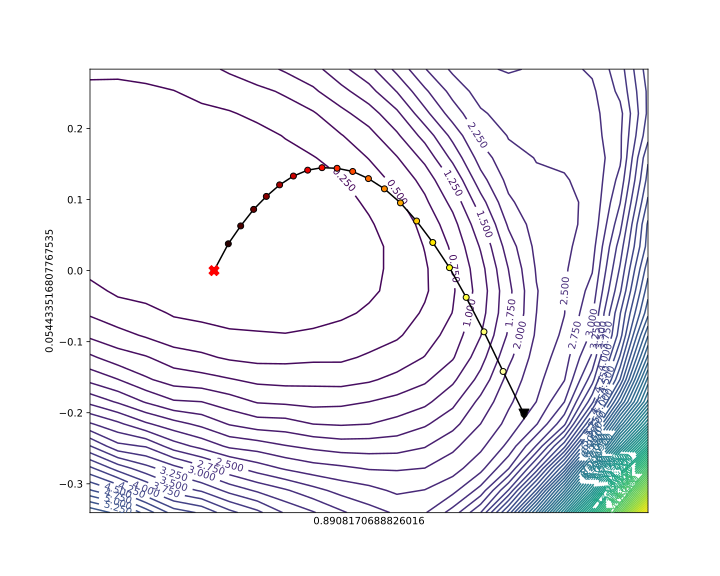

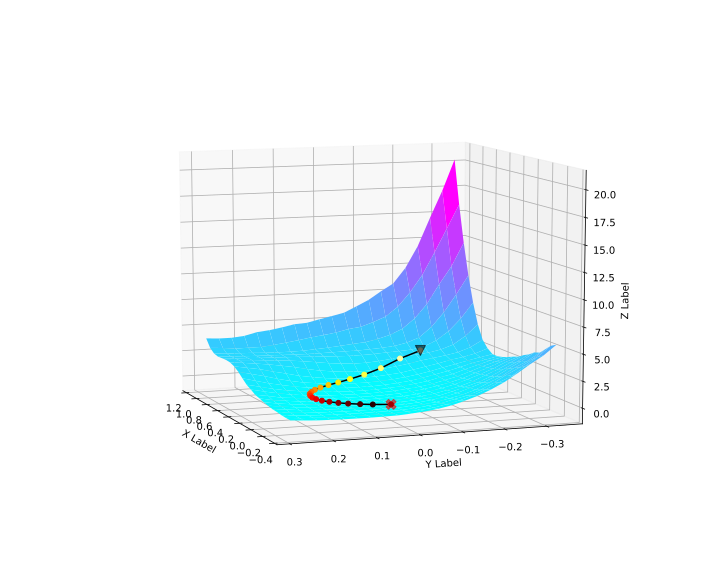

In [4]:
# Mini-Batch SGD with batch-size 16 and learning rate 0.35
show_svg("./visualizations/SGD_with_variable_batch_size_16_0.35/SGD_with_variable_batch_size_16_0.35_2D_plot_pca_20.svg")
show_svg("./visualizations/SGD_with_variable_batch_size_16_0.35/SGD_with_variable_batch_size_16_0.35_3D_plot_pca_20.svg")

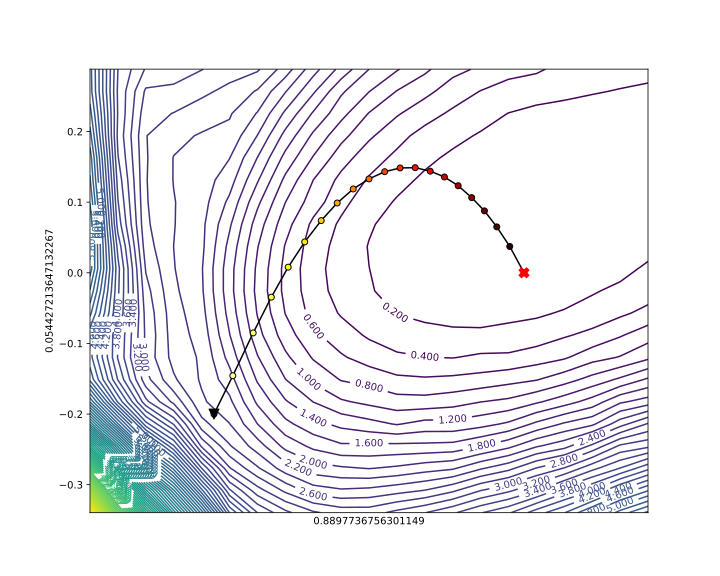

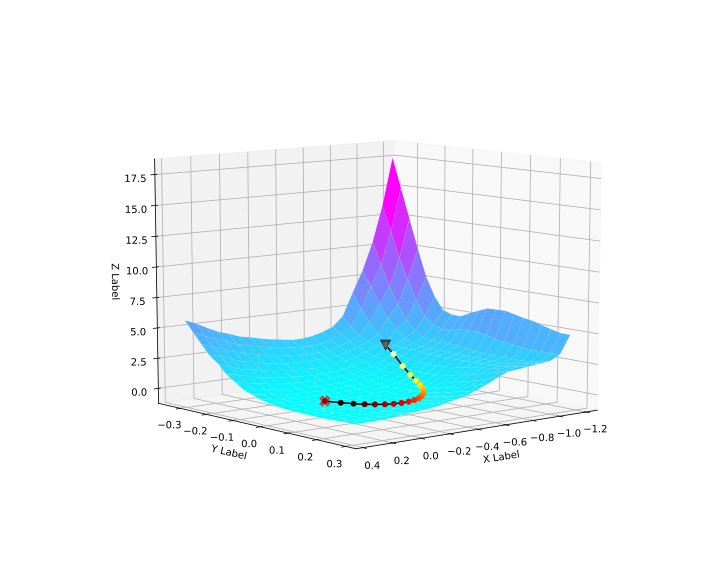

In [5]:
# Momentum with batch-size 16, learning rate 0.04 and gamma 0.9
show_svg("./visualizations/SGD_with_momentum_0.9_16_0.04/SGD_with_momentum_0.9_16_0.04_2D_plot_pca_20.svg")
show_svg("./visualizations/SGD_with_momentum_0.9_16_0.04/SGD_with_momentum_0.9_16_0.04_3D_plot_pca_20.svg")

## 6. Full training example <a name="full-training-example" />

### Create the experiment

In [6]:
# 10 epochs of momentum with batch-size 250 so that training will be fast
example_experiment = Experiment(name=f"training_example_momentum", # title of the experiment
                        optimizer_name="SGD_WITH_MOMENTUM", # which optimizer to use
                        params=dict(epochs=10, lr=0.04, batch_size=250, momentum=0.9)) # param momentum stands for gamma

### Run the experiment

In [7]:
# will run on cuda if possible and on cpu otherwise
# will save a checkpoint for every epoch
# will create results csv file
run_experiment(example_experiment)

running on device: cuda
Files already downloaded and verified
Files already downloaded and verified


  :   0%|          | 0/200 [00:00<?, ?it/s]

directory ./checkpoints\training_example_momentum was created
Epoch: [1/10]


  : 100%|██████████| 200/200 [00:15<00:00, 12.65it/s]


  Train Avg Loss: 1.5874 Acc: 0.4025
  testing...


  :   0%|          | 0/200 [00:00<?, ?it/s]

  Test Avg Loss: 1.3436 Acc: 0.5088
Epoch: [2/10]


  : 100%|██████████| 200/200 [00:14<00:00, 13.62it/s]


  Train Avg Loss: 1.1222 Acc: 0.5896
  testing...


  :   0%|          | 0/200 [00:00<?, ?it/s]

  Test Avg Loss: 1.0730 Acc: 0.6133
Epoch: [3/10]


  : 100%|██████████| 200/200 [00:14<00:00, 13.69it/s]


  Train Avg Loss: 0.9065 Acc: 0.6728
  testing...


  :   1%|          | 2/200 [00:00<00:15, 12.66it/s]

  Test Avg Loss: 1.3006 Acc: 0.5845
Epoch: [4/10]


  : 100%|██████████| 200/200 [00:14<00:00, 13.72it/s]


  Train Avg Loss: 0.7622 Acc: 0.7295
  testing...


  :   1%|          | 2/200 [00:00<00:15, 12.99it/s]

  Test Avg Loss: 0.9078 Acc: 0.6789
Epoch: [5/10]


  : 100%|██████████| 200/200 [00:14<00:00, 13.74it/s]


  Train Avg Loss: 0.6515 Acc: 0.7696
  testing...


  :   1%|          | 2/200 [00:00<00:15, 12.91it/s]

  Test Avg Loss: 0.7626 Acc: 0.7405
Epoch: [6/10]


  : 100%|██████████| 200/200 [00:14<00:00, 13.75it/s]


  Train Avg Loss: 0.5631 Acc: 0.8012
  testing...


  :   1%|          | 2/200 [00:00<00:16, 12.25it/s]

  Test Avg Loss: 0.7863 Acc: 0.7319
Epoch: [7/10]


  : 100%|██████████| 200/200 [00:14<00:00, 13.76it/s]


  Train Avg Loss: 0.5057 Acc: 0.8230
  testing...


  :   1%|          | 2/200 [00:00<00:15, 13.07it/s]

  Test Avg Loss: 0.8239 Acc: 0.7186
Epoch: [8/10]


  : 100%|██████████| 200/200 [00:14<00:00, 13.85it/s]


  Train Avg Loss: 0.4430 Acc: 0.8440
  testing...


  :   0%|          | 0/200 [00:00<?, ?it/s]

  Test Avg Loss: 1.1296 Acc: 0.6783
Epoch: [9/10]


  : 100%|██████████| 200/200 [00:14<00:00, 13.56it/s]


  Train Avg Loss: 0.3936 Acc: 0.8615
  testing...


  :   1%|          | 2/200 [00:00<00:14, 13.25it/s]

  Test Avg Loss: 0.8557 Acc: 0.7388
Epoch: [10/10]


  : 100%|██████████| 200/200 [00:14<00:00, 13.67it/s]


  Train Avg Loss: 0.3429 Acc: 0.8783
  testing...
  Test Avg Loss: 0.8694 Acc: 0.7391
Training took 168.12 seconds


### Read results csv file and create visualizations

In [8]:
df_training_example = pd.read_csv("./experiments_stats/" + example_experiment.name + ".csv")
# make sure to only read the newest experiment results
df_training_example = df_training_example.groupby("experiment_id").get_group(df_training_example["experiment_id"].max())
df_training_example.head()

,experiment_id,experiment_title,epoch,epoch_amount,train_avg_loss,train_acc,test_avg_loss,test_acc,experiment_params,timestamp
0,0,training_example_momentum,1,10,1.587443,0.40246,1.343582,0.5088,"{""optimizer_name"": ""SGD_WITH_MOMENTUM"", ""lr_sc...",2020-01-21 20:12:43.665285
1,0,training_example_momentum,2,10,1.122238,0.58964,1.073027,0.6133,"{""optimizer_name"": ""SGD_WITH_MOMENTUM"", ""lr_sc...",2020-01-21 20:13:00.446452
2,0,training_example_momentum,3,10,0.906543,0.67280,1.300644,0.5845,"{""optimizer_name"": ""SGD_WITH_MOMENTUM"", ""lr_sc...",2020-01-21 20:13:17.173474
3,0,training_example_momentum,4,10,0.762198,0.72950,0.907836,0.6789,"{""optimizer_name"": ""SGD_WITH_MOMENTUM"", ""lr_sc...",2020-01-21 20:13:33.828408
4,0,training_example_momentum,5,10,0.651533,0.76958,0.762594,0.7405,"{""optimizer_name"": ""SGD_WITH_MOMENTUM"", ""lr_sc...",2020-01-21 20:13:50.480408


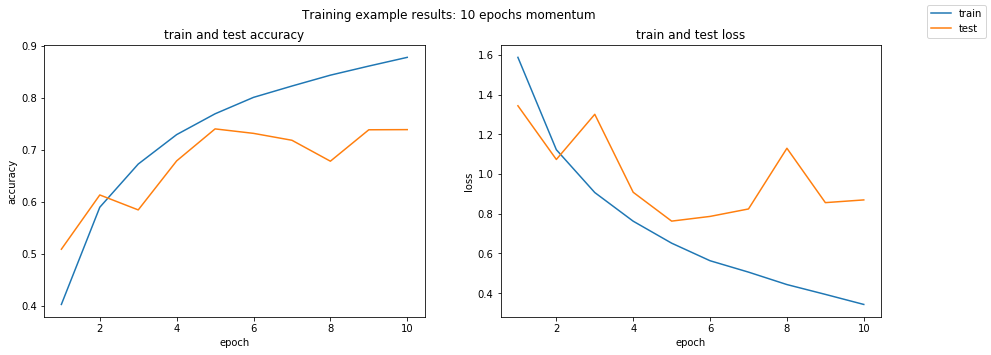

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw=dict(hspace=0.35))
fig.suptitle("Training example results: 10 epochs momentum")
left, right = axs[0], axs[1]

left.plot(df_training_example["epoch"], df_training_example[["train_acc", "test_acc"]])
left.set_title("train and test accuracy")
left.set_ylabel("accuracy")
left.set_xlabel("epoch")

right.plot(df_training_example["epoch"], df_training_example[["train_avg_loss", "test_avg_loss"]])
right.set_title("train and test loss")
right.set_ylabel("loss")
right.set_xlabel("epoch")

fig.legend(["train", "test"])

### Create visualizations from checkpoints with GradVis

In [10]:
# bare resnet model
bare_model = resnets.resnet20_cifar()
# cifar_data is the folder in which TorchVision stored the CIFAR-10 dataset
# train_vis_function is the training method that GradVis uses
train_vis_function = TrainVisCIFAR10("./cifar_data").get_train_vis_function()

create_plots_from_checkpoints(bare_model,
                              train_vis_function,
                              checkpoints_path="./checkpoints/training_example_momentum",
                              checkpoint_base_filename="training_example_momentum",
                              vis_output_dir="./visualizations/training_example_momentum",
                              vis_output_base_filename="training_example_momentum",
                              amount=-1, # use all available checkpoints
                              loss_3D_degrees=80) # rotation of the 3D plot around z-axis

Files already downloaded and verified
directory ./visualizations/training_example_momentum was created
Calculating PCA directions...
Principal [0.88914915 0.06697185]
Normalizing...
Calculating coefficients...


  0%|          | 0/11 [00:00<?, ?it/s]

Calculating Z-values of paths...


  0%|          | 0/11 [00:00<?, ?it/s]

Calculating loss landscape...


100%|██████████| 11/11 [02:23<00:00, 13.08s/it]


Saving figure ./visualizations/training_example_momentum\training_example_momentum_2D_plot_pca_10.svg
Saving figure ./visualizations/training_example_momentum\training_example_momentum_3D_plot_pca_10.svg


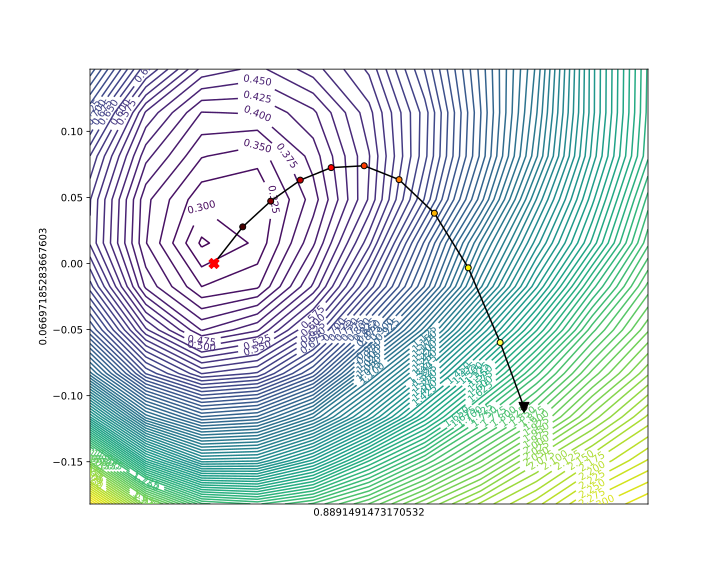

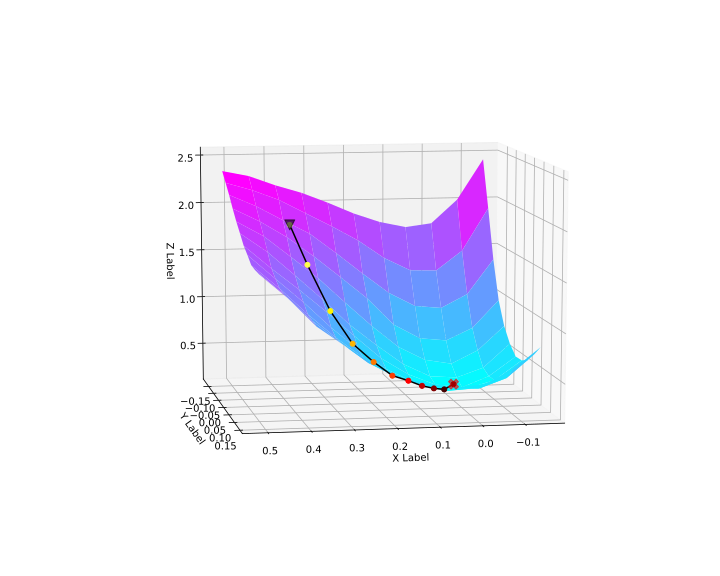

In [11]:
# 2D and 3D plots
show_svg("./visualizations/training_example_momentum/training_example_momentum_2D_plot_pca_10.svg")
show_svg("./visualizations/training_example_momentum/training_example_momentum_3D_plot_pca_10.svg")

## 7. Sources <a name="sources" />

- https://ruder.io/optimizing-gradient-descent/
- https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
- https://paperswithcode.com/sota/image-classification-on-cifar-10
- https://arxiv.org/abs/1912.11370v1 --> paper for the best CIFAR-10 results
- https://courses.d2l.ai/berkeley-stat-157/units/optimization.html
- https://courses.d2l.ai/berkeley-stat-157/units/adam.html
- https://www.cs.toronto.edu/~kriz/cifar.html
- https://www.deeplearningbook.org/
- https://de.coursera.org/lecture/deep-neural-network/rmsprop-BhJlm
- https://nbviewer.jupyter.org/url/courses.d2l.ai/berkeley-stat-157/slides/4_30/gd-sgd.ipynb
- https://nbviewer.jupyter.org/url/courses.d2l.ai/berkeley-stat-157/slides/5_2/momentum.ipynb
- https://towardsdatascience.com/linear-regression-using-gradient-descent-97a6c8700931
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#loading-and-normalizing-cifar10
- https://pytorch.org/docs/stable/optim.html#algorithms
- https://keras.io/optimizers/
- https://github.com/cc-hpc-itwm/GradVis
- https://arxiv.org/abs/1909.12108 --> paper for GradVis
- https://mlfromscratch.com/optimizers-explained/
- https://mlfromscratch.com/neural-networks-explained/